In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import librosa
import numpy as np

pose_root = "/content/drive/MyDrive/Trial_db/pro_json"
audio_root = "/content/drive/MyDrive/Trial_db/pro_audio"
data = []
labels = []

label_mapping = {
    'salsa': 0,
    'tap': 1,
    'ballet': 2,
    'contemporary': 3,
    'hip_hop': 4
}

for label_folder in os.listdir(pose_root):
    label_folder_path = os.path.join(pose_root, label_folder)
    for filename in os.listdir(label_folder_path):
        if filename.endswith('.json'):
            # Load the pose data from the JSON file
            with open(os.path.join(label_folder_path, filename), "r") as f:
                pose_data = json.load(f)
            pose_data = np.array(pose_data)

            # Extract features from pose data
            distances = np.sqrt(np.sum((pose_data[:, 0, :] - pose_data[:, 1, :])**2, axis=-1))
            v1 = pose_data[:, 1, :] - pose_data[:, 0, :]
            v2 = pose_data[:, 1, :] - pose_data[:, 2, :]
            angles = np.arccos(np.sum(v1*v2, axis=-1) / (np.linalg.norm(v1, axis=-1) * np.linalg.norm(v2, axis=-1)))
            pose_features = np.stack([distances, angles], axis=-1)
            pose_features_mean = np.mean(pose_features, axis=0)

            # Load the corresponding audio file
            audio_filename = filename.replace('_data.json', '_processed.wav')

            audio, sr = librosa.load(os.path.join(audio_root, label_folder, audio_filename))

            # Compute the spectrogram of the audio signal and convert it to logarithmic scale
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
            log_spectrogram = librosa.power_to_db(spectrogram)
            log_spectrogram_mean = np.mean(log_spectrogram, axis=1)

            # Concatenate pose and audio features
            features = np.concatenate([pose_features_mean, log_spectrogram_mean])

            data.append(features)

            # The label is determined by the folder name
            label = label_mapping[label_folder.lower()]
            labels.append(label)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)


In [ ]:
print(data), print(labels)

[[ 2.15085123e-02  1.75697221e+00 -3.37842979e+01 ... -6.21707535e+01
  -6.25044746e+01 -6.31710281e+01]
 [ 1.72706956e-02  1.82099307e+00 -1.87621670e+01 ... -5.05472107e+01
  -5.05552444e+01 -5.11638298e+01]
 [ 1.23731910e-02  1.78958025e+00 -1.77190857e+01 ... -5.13020325e+01
  -5.20816040e+01 -5.31114731e+01]
 ...
 [ 1.72736278e-02  1.83838585e+00 -8.91963673e+00 ... -4.21048393e+01
  -4.46740417e+01 -5.34418106e+01]
 [ 2.02399118e-02  1.86143073e+00 -3.85895424e+01 ... -4.44532890e+01
  -4.69616814e+01 -5.45545959e+01]
 [ 1.84674105e-02  1.86962248e+00 -1.08338108e+01 ... -2.62883911e+01
  -3.25529404e+01 -4.40880585e+01]]
[2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


(None, None)

In [3]:
data = data.reshape((data.shape[0], data.shape[1], 1))
labels = labels.reshape((labels.shape[0], 1))
data, label

(array([[[ 2.15085123e-02],
         [ 1.75697221e+00],
         [-3.37842979e+01],
         ...,
         [-6.21707535e+01],
         [-6.25044746e+01],
         [-6.31710281e+01]],
 
        [[ 1.72706956e-02],
         [ 1.82099307e+00],
         [-1.87621670e+01],
         ...,
         [-5.05472107e+01],
         [-5.05552444e+01],
         [-5.11638298e+01]],
 
        [[ 1.23731910e-02],
         [ 1.78958025e+00],
         [-1.77190857e+01],
         ...,
         [-5.13020325e+01],
         [-5.20816040e+01],
         [-5.31114731e+01]],
 
        ...,
 
        [[ 1.72736278e-02],
         [ 1.83838585e+00],
         [-8.91963673e+00],
         ...,
         [-4.21048393e+01],
         [-4.46740417e+01],
         [-5.34418106e+01]],
 
        [[ 2.02399118e-02],
         [ 1.86143073e+00],
         [-3.85895424e+01],
         ...,
         [-4.44532890e+01],
         [-4.69616814e+01],
         [-5.45545959e+01]],
 
        [[ 1.84674105e-02],
         [ 1.86962248e+00],
    

In [ ]:
print(data.shape), print(labels.shape)

(53, 130, 1)
(53, 1)


(None, None)

In [4]:
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]




In [5]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% remaining data (validation + test)
X_train, X_remaining, y_train, y_remaining = train_test_split(data, labels, test_size=0.2, random_state=42)

# Split remaining data (20%) into 50% validation and 50% test
X_validation, X_test, y_validation, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2

SEQUENCE_LENGTH = data.shape[1]  # Please replace this with actual sequence length
NUM_CLASSES = 5  # Number of dance types

# Define the model

model = Sequential([
    Conv1D(256, 3, input_shape=(SEQUENCE_LENGTH, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Conv1D(256, 3),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(256, 3),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Conv1D(256, 3),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    MaxPooling1D(2),
    Dropout(0.3),
    LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    GRU(256, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])


# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_validation, y_validation))





Epoch 1/200
2/2 [==============================] - 9s 1s/step - loss: 2.9519 - accuracy: 0.2143 - val_loss: 3.0132 - val_accuracy: 0.4000
Epoch 2/200
2/2 [==============================] - 0s 71ms/step - loss: 3.0655 - accuracy: 0.2381 - val_loss: 3.1037 - val_accuracy: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 0s 63ms/step - loss: 2.4215 - accuracy: 0.5000 - val_loss: 3.1626 - val_accuracy: 0.4000
Epoch 4/200
2/2 [==============================] - 0s 60ms/step - loss: 2.6511 - accuracy: 0.3571 - val_loss: 3.5769 - val_accuracy: 0.0000e+00
Epoch 5/200
2/2 [==============================] - 0s 78ms/step - loss: 2.3053 - accuracy: 0.5714 - val_loss: 2.8998 - val_accuracy: 0.2000
Epoch 6/200
2/2 [==============================] - 0s 69ms/step - loss: 2.4430 - accuracy: 0.4048 - val_loss: 3.8858 - val_accuracy: 0.0000e+00
Epoch 7/200
2/2 [==============================] - 0s 71ms/step - loss: 2.6011 - accuracy: 0.3810 - val_loss: 3.8318 - val_accuracy: 0.0000e+00
Epoch 

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 [==============================] - 0s 29ms/step - loss: 3.1724 - accuracy: 0.6000
Validation Loss: 3.1724
Validation Accuracy: 0.6000
1/1 [==============================] - 0s 28ms/step - loss: 3.3732 - accuracy: 0.5000
Test Loss: 3.3732
Test Accuracy: 0.5000


In [ ]:
from sklearn.metrics import f1_score

# Assuming you have already trained and evaluated your model

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_labels, average='weighted')
print("F1 Score:", f1)


1/1 [==============================] - 1s 766ms/step
F1 Score: 0.5


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have already trained and evaluated your model

# Make predictions on the test data
y_pred = model.predict(X_test)

# Flatten the predictions and true labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)


1/1 [==============================] - 0s 33ms/step
RMSE: 2.972092416687835


In [ ]:
# Save the model
model.save('dance_model1_lstmgru.h5')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
import json
import librosa
import numpy as np

def preprocess_single_data(json_file, audio_file):
    # Load the pose data from the JSON file
    with open(json_file, "r") as f:
        pose_data = json.load(f)
    pose_data = np.array(pose_data)

    # Extract features from pose data
    distances = np.sqrt(np.sum((pose_data[:, 0, :] - pose_data[:, 1, :])**2, axis=-1))
    v1 = pose_data[:, 1, :] - pose_data[:, 0, :]
    v2 = pose_data[:, 1, :] - pose_data[:, 2, :]
    angles = np.arccos(np.sum(v1*v2, axis=-1) / (np.linalg.norm(v1, axis=-1) * np.linalg.norm(v2, axis=-1)))
    pose_features = np.stack([distances, angles], axis=-1)
    pose_features_mean = np.mean(pose_features, axis=0)

    # Load the corresponding audio file
    audio, sr = librosa.load(audio_file, sr=None)

    # Compute the spectrogram of the audio signal and convert it to logarithmic scale
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram)
    log_spectrogram_mean = np.mean(log_spectrogram, axis=1)

    # Concatenate pose and audio features
    features = np.concatenate([pose_features_mean, log_spectrogram_mean])

    return features

# Set the paths to the JSON file and the corresponding audio file for testing
json_file = "/content/drive/MyDrive/Summer_Internship_Data/Test/trial_data.json"
audio_file = "/content/drive/MyDrive/Summer_Internship_Data/Test/trial_processed.wav"

# Preprocess the single data
# preprocessed_data = preprocess_single_data(json_file, audio_file)
# print(preprocessed_data)

# Use the preprocessed_data for further processing or prediction


In [ ]:
from tensorflow.keras.models import load_model

# Set the path to the saved model
model_path = "/content/dance_model1_test.h5"

# Load the saved model
model = load_model(model_path)

# Preprocess the single data
preprocessed_data = preprocess_single_data(json_file, audio_file)

# Reshape the preprocessed data to match the model's input shape
preprocessed_data = preprocessed_data.reshape(1, preprocessed_data.shape[0], 1)

# Make predictions using the loaded model
predictions = model.predict(preprocessed_data)

# Get the predicted dance form
predicted_dance_form = np.argmax(predictions)

# Print the predicted dance form
print("Predicted Dance Form:", predicted_dance_form)


1/1 [==============================] - 1s 1s/step
Predicted Dance Form: 0


#F1 Score

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Trial_db/dance_model1_83.h5')

# Prepare your test data and true labels
# X_test = ...  # Test data
# y_true = ...  # True labels

# Make predictions using the loaded model
y_pred = model.predict(X_test)

# Convert predicted labels to the desired format if needed
y_pred = np.argmax(y_pred, axis=1)  # Convert from one-hot encoded to categorical labels

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print('F1 Score:', f1)



1/1 [==============================] - 2s 2s/step
F1 Score: 1.0


1/1 [==============================] - 0s 36ms/step
Confusion Matrix:
[[0 2 3 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


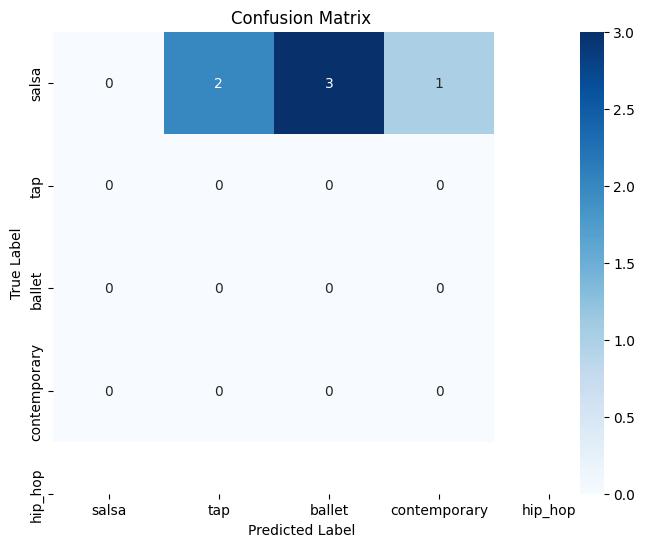

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels and input data: y_test and X_test

# Convert one-hot encoded y_test to class indices
y_true_labels = np.argmax(y_test, axis=1)

# Make predictions using the loaded model
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Get the class labels
class_labels = ['salsa', 'tap', 'ballet', 'contemporary', 'hip_hop']

# Calculate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# Load the saved model
model = load_model('/content/drive/MyDrive/dance_model1_83.h5')

# Prepare your test data and true labels
# X_test = ...  # Test data
# y_true = ...  # True labels

# Make predictions using the loaded model
y_pred = model.predict(X_test)

# Convert predicted labels to the desired format if needed
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert from one-hot encoded to categorical labels

# Calculate the RMSE for each target variable (assuming y_true and y_pred_labels are 1D arrays)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_labels))

print('RMSE:', rmse)


1/1 [==============================] - 1s 1s/step
RMSE: 1.9578900207451218


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
# Assuming you have your true labels (target variable) stored in y_true
# Replace y_true with your actual target variable data
model = load_model('/content/drive/MyDrive/dance_model1_83.h5')
y_pred = model.predict(X_test)
y_min = np.min(y_train)
y_max = np.max(y_train)

print('Minimum:', y_min)
print('Maximum:', y_max)


1/1 [==============================] - 2s 2s/step
Minimum: 0
Maximum: 4


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2

SEQUENCE_LENGTH = data.shape[1]  # Please replace this with actual sequence length
NUM_CLASSES = 5  # Number of dance types

# Define the model

model = Sequential([
    Conv1D(256, 3, input_shape=(SEQUENCE_LENGTH, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Conv1D(256, 3),
    Conv1D(256, 3),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Conv1D(256, 3),
    BatchNormalization(),
    LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    GRU(256, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 128, 256)          1024      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 256)         1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 126, 256)          196864    
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 256)          196864    
                                                                 
 batch_normalization_6 (Batc  (None, 124, 256)         1024      
 hNormalization)                                      